In [22]:

from maelstrom.genotype import GeneticTree
from maelstrom.population import GeneticProgrammingPopulation
import gymnasium as gym
from maelstrom.island import GeneticProgrammingIsland
from snake_eyes import read_config
import matplotlib.pyplot as plt

# Before You Code
---

Before coding, users should define a configuration file for their expirement. See the configs folder for an example. The expirment folder tells maelstrom certain variables about your expirement, such as the number of evaluations to complete. 

# Define Evaluation Function
---

The evaluation function is one of the core pieces of evolutionary computing and the Maelstrom framework. Maelstrom allows you to create and use your own evaluation function for maximum customizability. To use the defined evaluation function, all you have to do is specify the name of the function in your config file. 

In the evaluation function we defined for the swimmer gym, we step through each frame of the gym for each individual and allow the individual genotype to calculate a movement vector based on the observation space using strong type GP. We then assign a reward based on the results of the action. Following that, some information regarding performance is collected and data is gathered. The return from the evaluation function should be a python dictionary containing the data you would like to save in the log field on the island object and the number of evaluations. 

In [23]:
def evaluation(swimmers: GeneticProgrammingPopulation, **kwargs):
    env = kwargs["env"]
    if swimmers.population is None:
        raise ValueError("Population is empty.")
    for individual in swimmers.population:
        individual.fitness = 0
        observation, info = env.reset()

        for _ in range(1_000):
            action = individual.execute(observation)
            observation, reward, terminated, truncated, info = env.step(action)
            individual.fitness += reward

            if terminated or truncated:
                break
    try:
        swimmers.best.append(max(swimmers.population, key=lambda x: x.fitness))
    except Exception:
        swimmers.best = [max(swimmers.population, key=lambda x: x.fitness)]

    return gather_data(swimmers), len(swimmers.population)


#######################################
# Simple data collection and plotting #
#######################################
def gather_data(
    swimmers: GeneticProgrammingPopulation,
    evals=None,
) -> dict:
    """
    Gather data from the population
    """
    if swimmers.population is None:
        raise ValueError("Pops must not be None")
    log = {}
    fitness = [i.fitness for i in swimmers.population]
    log["avg_fitness"] = sum(fitness) / len(fitness)
    log["max_fitness"] = max(fitness)
    if evals:
        log["evals"] = evals
    return log


def plot_data(data: list[dict], title: str, y_label: str, x_label: str):
    """
    Plots the data from the log
    """
    # first, write data to file
    print(data)
    with open("data.txt", "w") as f:
        # data in the format of {"avg_fitness":[], "max_fitness":[]}
        # one column for generation number, which corresponds to the index
        # one column for the average fitness
        # one column for the max fitness

        # write the header
        f.write(f"{x_label}\t|\t{y_label}\t|\tMax Fitness\n")
        for i, _ in enumerate(data["avg_fitness"]):
            f.write(f"{i}\t|\t{data['avg_fitness'][i]}\t|\t{data['max_fitness'][i]}\n")

    fig, ax = plt.subplots()
    ax.set_ylim([-500, 500])
    ax.plot([i for i, _ in enumerate(data["avg_fitness"])], data["avg_fitness"])
    ax.set(xlabel=x_label, ylabel=y_label, title=title)
    plt.show()





# Design Primitives
---
Next we defined the primitives to use for this experiment. Primitives can be defined in a separate file as well, as long as they are imported into the file being executed, the "declare_primitive" wrapper will register them. Here, we defined a few types: 

- Output: This is the vector to be output by the tree created
- Float: This is the floating point values from the calculations done within the primtives. Note: The names of the primitives do not determine what type they are. I could have called this type "integer" and it would still really represent the type of floating point values calculated from the primitives. The point of the types is to help build the tree, and determine what nodes can be children or parents of what nodes. For example, if we defined a primitive that takes in two floats, when the tree is built, it knows that that primitives node needs to nodes that output the "float" type as children. 

The GENERAL variable represents a role. This is useful for the configuration files. It allows you to assign different populations to different roles. This means that if I was doing competitive coevolution, I might want to have different populations with different primitives. I could do this by assigning certain primitives to different roles, then giving certain populations that role in the configuration file. 

In [24]:

"""

Primitives for the genetic tree.

The declare_primitives wrapper follows the following signature:
    declare_primitives(
        role: str,
        output_type: str,
        input_types: Tuple[str, ...],
    )

"""

OUTPUT = "OUTPUT"
FLOAT = "FLOAT"
GENERAL = "GENERAL"

@GeneticTree.declare_primitive(GENERAL, OUTPUT, (FLOAT, FLOAT))
def create_output(float_1, float_2):
    """Output a tuple of two floats, where each float is coerced to be between -1 and 1."""
    return float_1, float_2


@GeneticTree.declare_primitive(GENERAL, FLOAT, (FLOAT, FLOAT))
def add(float_1, float_2):
    """Add two floats."""
    return float_1 + float_2


@GeneticTree.declare_primitive(GENERAL, FLOAT, (FLOAT, FLOAT))
def sub(float_1, float_2):
    """Add two floats."""
    return float_1 - float_2


@GeneticTree.declare_primitive(GENERAL, FLOAT, (FLOAT, FLOAT))
def mul(float_1, float_2):
    """Add two floats."""
    return float_1 * float_2


@GeneticTree.declare_primitive(GENERAL, FLOAT, (FLOAT, FLOAT))
def div(float_1, float_2):
    """Add two floats."""
    return float_1 / float_2 if float_2 != 0 else float_1


@GeneticTree.declare_primitive(GENERAL, FLOAT, ())
def context_0(context):
    """Get the first context value."""
    return context[0]


@GeneticTree.declare_primitive(GENERAL, FLOAT, ())
def context_1(context):
    """Get the second context value."""
    return context[1]


@GeneticTree.declare_primitive(GENERAL, FLOAT, ())
def context_2(context):
    """Get the third context value."""
    return context[2]


@GeneticTree.declare_primitive(GENERAL, FLOAT, ())
def context_3(context):
    """Get the fourth context value."""
    return context[3]


@GeneticTree.declare_primitive(GENERAL, FLOAT, ())
def context_4(context):
    """Get the fifth context value."""
    return context[4]


@GeneticTree.declare_primitive(GENERAL, FLOAT, ())
def context_5(context):
    """Get the sixth context value."""
    return context[5]


@GeneticTree.declare_primitive(GENERAL, FLOAT, ())
def context_6(context):
    """Get the seventh context value."""
    return context[6]


@GeneticTree.declare_primitive(GENERAL, FLOAT, ())
def context_7(context):
    """Get the eighth context value."""
    return context[7]


# Comparison to Primitives in the DEAP Framework
---
One of the most popular Genetic Programming frameworks is called DEAP. DEAP takes a similar approach to creating primitives that we will give an example of here. This will be a markdown examination and not a fully implemented / runnable comparison. All of the primitives defined below would be useful primtiives for our Swimmer example.

All examples are pulled from the following link: https://deap.readthedocs.io/en/master/tutorials/advanced/gp.html

Here is a weak type example from their documentation:
```python
pset = PrimitiveSet("main", 2)
pset.addPrimitive(max, 2)
pset.addPrimitive(operator.add, 2)
pset.addPrimitive(operator.mul, 2)
pset.addTerminal(3)
```

The first line creates a primitive set. Its arguments are the name of the procedure it will generate ("main") and its number of inputs, 2. The next three lines add functions as primitives. The first argument is the function to add and the second argument the function arity. The last line adds a constant terminal. Currently, the default names for the arguments are "ARG0" and "ARG1". 

This implemntation is similar to Maelstrom. A function is defined, as well as the number of inputs. This helps build the structure of the tree genotype. The main difference here is the confusion with writing functions that manipulate the arguments. It is not as clear as within the functions built with Maelstrom. Additionally, these primitives are registered with the implementation of the expirment, whereas with Maelstrom, any imported primitives using the wrapper will be used. This makes sharing primitives across experiments more complicated. For example, most of the primitives within the repo that is paired with this paper only needed to be written once and then imported, no extra work to reuse generic weak type primitives. However, using DEAP, these primitives would have needed to be registered for each example, making it more painful to use well written primitives that can span multiple problem domains. 

One of the most notable differences is the lack of roles. Looking at DEAP's documentation, there is no obvious way to separate out different primitives for different populations easily. That is because DEAP does not treat coevolution as a first class citizen, while Maelstrom heavily focuses on the practice. 

Here is an additional example with strong type GP:

```python
pset = PrimitiveSetTyped("main", [bool, float], float)
pset.addPrimitive(operator.xor, [bool, bool], bool)
pset.addPrimitive(operator.mul, [float, float], float)
pset.addPrimitive(if_then_else, [bool, float, float], float)
pset.addTerminal(3.0, float)
pset.addTerminal(1, bool)
```

This is also similar to our implementation of strong type primitives. Specifically, the output type of a primitive must match the input type of another one for them to be connected. However, there are a few immediately obvious differences. The first is that DEAP uses strict Python types for its type definition. While this is intuitive, it also reduces flexibility. 

# Create a Driver
---
The driver is simply the function that creates an instance of a population and runs the experiment.

In [25]:
def driver():
    env = gym.make("Swimmer-v4", ctrl_cost_weight=0.01)
    config = read_config("./configs/main.cfg", globals(), locals())
    island = GeneticProgrammingIsland(**config["ISLAND"], **config)
    island.populations["swimmers"].best = []
    island.run()

    plot_data(island.log, "Swimmer", "Fitness", "Generation")

    # find the best champion and render
    best = max(island.populations["swimmers"].best, key=lambda x: x.fitness)
    print("Best agent's fitness: ", best.fitness)
    genotype = best
    env.unwrapped.render_mode = "human"
    observation, _ = env.reset()
    fitness = 0
    for _ in range(1_000):
        action = genotype.execute(observation)
        observation, reward, terminated, truncated, _ = env.step(action)
        env.render()
        fitness += reward

        if terminated or truncated:
            break
    print("Fitness during rendering: ", fitness)
    env.close()

# Execution
---
It bears noting when examining the resulting graph of fitness that there are frequent large valleys. This is due to the punishment for large movements. Essentially, since we are not applying any scaling to the vector output, the force values will frequently be above a "large movement" threshold defined in the gym that has a high default penalty value. This means that one mutation will cause one individual to have a VERY low fitness that brings down the average significantly.

  0%|          | 0/50000 [00:00<?, ? evals/s]

{'avg_fitness': [-8.761617509291108e+44, -1.972562805140049e+29, -122523679.58480921, -150276.8560043448, -1812719597.444707, -492665.32404421875, -43731.15084314361, -200.68336615058308, -1473.7888098782246, 124.13266630605035, 127.21838185030305, 134.5778663431752, 138.501024313368, 139.16423461049934, 141.21193437256832, 161.99001663947573, 148.382764928689, 150.0381971434235, 146.26011632055378, -36135212.3373698, -188728.44574409406, -195.8023989475195, 146.97120228663672, 149.8298109909443, 148.74653718358007, 143.29812147509767, -3631.125040967504, 145.0947899661232, -4563.285594822098, 149.13901551616638, 149.6646131015457, 153.24369440128933, 144.88016316342026, 149.6141473725831, -45036003270.312874, 154.00634969054366, 141.05249337483548, 149.35258625976434, 148.94968428617935, 150.38084854758822, 149.623965712553, -4070.952802084765, 150.9122763546864, 155.57320451477906, -19112.204679560742, 141.35634550633685, -857878228.2048662, 147.02413089047667, 149.33219121648574, 14

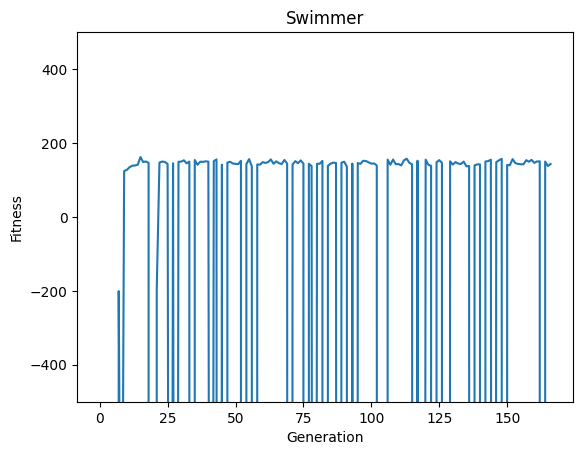

Best agent's fitness:  203.86418129942487


/home/roberte777/coding/python/maelstrom-examples/swimmer/.venv/lib/python3.11/site-packages/glfw/__init__.py:916: GLFWError: (65537) b'The GLFW library is not initialized'
  warnings.warn(message, GLFWError)


KeyboardInterrupt: 

In [26]:
driver()